# XAFS Data Processing 2

Here we'll use Larch to replicate the examples from [Bruce Ravell's tutorial](https://www.diamond.ac.uk/Instruments/Spectroscopy/Techniques/XAS.html) at diamond for XAFS data processing. 

This notebook tries to replicate the results during the [second session on processing](https://vimeo.com/340215763)

The main things to look up for in this notebook are:

  1. read data from an ascii file
  2. do normalisation (calculate and plot mu)
  3. do XAFS background subtraction with autobk()
  4. do XAFS Fourier transform with xfft()
  5. modify the background parameter and observe the differences it makes to the plots, compared to the initial default
 
  
For more details, see https://xraypy.github.io/xraylarch/xafs/

We'll start with loading the files from scratch and getting the groups to the state they were at the end of the first session on processing.

## Athena defaults
After loading athena presents the oscilatory spectrum, the r-space and the q-space. Athena uses several default parameter values. Using those same default values it is possible to try and reproduce the initial results for loading a file, starting with normalisation. 

The default values on athena are shown in the table below.

|Area | Varialbe      | Value    |
|:-----:|:------------- |:--------:|
| Current Group| File | XAFSExamples/Fe_standards/Fe_lepidocrocite.000|
|| Element       |   26 Iron |
|| Edge |   K |
|Background removal and normalisation| E0|7128.74769|
||rbkg|1.0|
||flaten normalised data|true|
||k-weight| 2|
||normalization order|3|
||pre-edge range| \[ -150.00, -30.00\]|
| |Edge step| 0.461424|
| |fix|false
| |normalization range| \[ 150.00, 742.610\]|
| |spline range in k| \[ 0, 14.871\]|
| |spline range in e| \[ 0, 842.5651\]|
| |spline clamps low| none|
| |spline clamps low| strong|
| |standard|none|
|Forward fourier transform|k-range| \[ 3.000, 12.871\]|
| |dk|1|
| |window|Hanning|
| |arbitrary k-weight|0.5|
| |phase correction|false|
|Backward fourier transform|R-range| \[ 1, 3\]|
| |dR|0.0|
| |window|Hanning|
|Plotting|plot multiplier|1|
| |y-axis offset|0|
| |e-min|-200|
| |e-max|800|


## Restore session status
Restoring the session requires:
 1. loading a dataset, 
 2. performing normalisation, background extraction, and curve fitting,
 3. creating a copy of the  group, modifying the parameter and recalculating.

The available readers are read_ascii(), read_xdi(), and read_gsexdi() for text column files and read_athena() and extract_athenagroup(), for Athena Project files.

In [1]:
# larch libraries
# reading data from text files
from larch.io import read_ascii
# copying and creating groups
from larch.utils import group2dict, dict2group
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# import plot labels to avoid having to type the markup
from larch.wxlib import plotlabels as plab
# calculate fourier transform
from larch.xafs import xftf

# additional libraries
from numpy import log
%matplotlib inline
import matplotlib.pyplot as plt

fe_xafs = read_ascii('XAFSExamples/Fe_standards/Fe_lepidocrocite.000')


# Calculate mu 
def get_mu(xafs_group):
    # calculate mu
    mu_e = log(abs(xafs_group.i0/xafs_group.it))
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu to the dictionary
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

# create a copy of the group
def copy_group(xafs_group):
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    #xafs_dict['filename']=xafs_dict['filename']+"_copy"
    new_group = dict2group(xafs_dict)
    new_group.filename = new_group.filename+"_copy" 
    return new_group

# these two lines help when formating subscripts and
# supperscripts for printing
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

 #######################################################
# |       Restore state of previous session           | #
# V                                                   V #
 #######################################################
# calculate mu and normalise with background extraction
fe_xafs = get_mu(fe_xafs)

# calculate pre-edge and post edge and add them to group
pre_edge(fe_xafs, group=fe_xafs)

# perform background removal
autobk(fe_xafs) # using defaults so no additional parameters are passed

# calculate fourier transform
xftf(fe_xafs, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

# create copy of initial group
fe_xafs_copy = copy_group(fe_xafs)

# redo calculations with modified bacground parameter
autobk(fe_xafs_copy, rbkg=0.2)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

(0.0, 6.0)

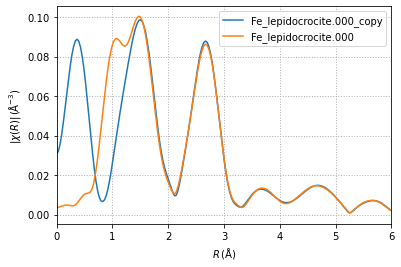

In [2]:
# plot magnitude in r-space
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

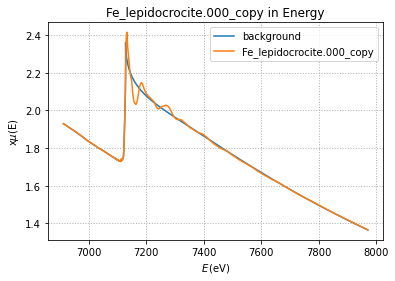

In [3]:
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.bkg, label='background')
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.mu, label=fe_xafs_copy.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(plab.energy)
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs_copy.filename+" in Energy")
plt.legend()

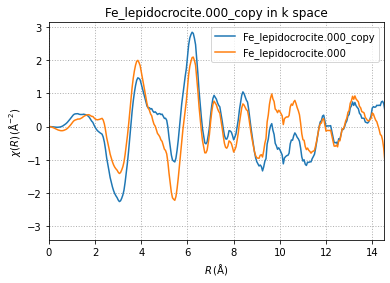

In [4]:
# https://vimeo.com/340207346 49:00
plt.plot(fe_xafs_copy.k, fe_xafs_copy.chi*fe_xafs_copy.k**2, label=fe_xafs_copy.filename)
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(2))
plt.title(fe_xafs_copy.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)
plt.legend()

As the previus plots show this is the state we reache on [the previous session](https://vimeo.com/340207346).
Now the work of session 2 starts

## Beckground tweaking
Making the background parameter small caused some issues, but so does changing it to a larger value. The following example shows what happens with a larger rbkg parameter

(0.0, 6.0)

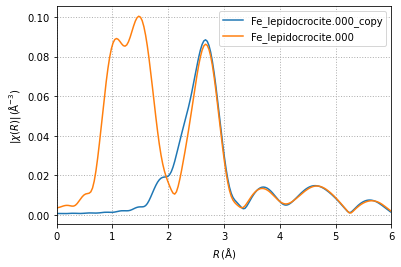

In [5]:
# https://vimeo.com/340215763 00:50
# change rbkg to a larger number and redo calculations
# with modified bacground parameter
autobk(fe_xafs_copy, rbkg=2.0)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

# plot magnitude in r-space to see results of change
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

When looking again in energy, the result is that the background and the signal are now closer than before changing the parameter

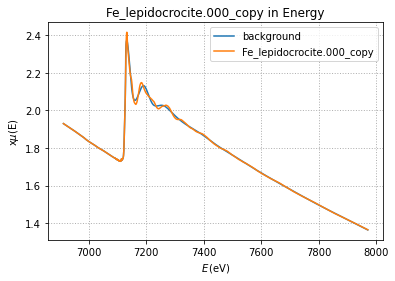

In [6]:
# https://vimeo.com/340215763 02:19
# visualise and interpret in energy
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.bkg, label='background')
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.mu, label=fe_xafs_copy.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(plab.energy)
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs_copy.filename+" in Energy")
plt.legend()

What happens if we slowly incremet rbkg, for instance from 0.2 to 0.4?

(0.0, 6.0)

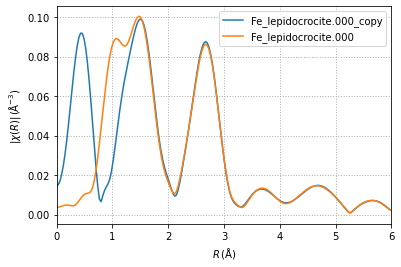

In [7]:
# https://vimeo.com/340215763 00:50
# change rbkg to a larger number and redo calculations
# with modified bacground parameter
autobk(fe_xafs_copy, rbkg=0.4)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

# plot magnitude in r-space to see results of change
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

In this case the result is different from the Athena examples shown in the tutorial, a closer match is obtained when changing the value to 0.8, as shown below.

In the tutorial, Ravel highlights how the changes have effects in the low frequencies, but in hte higher ones the results remain unchanged (when higher than 2)

(0.0, 6.0)

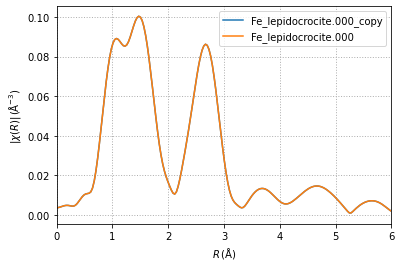

In [8]:
# https://vimeo.com/340215763 00:50
# change rbkg to a larger number and redo calculations
# with modified bacground parameter
autobk(fe_xafs_copy, rbkg=1.0)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

# plot magnitude in r-space to see results of change
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

Now see what happens after 1.0, example 1.2, in this case the peak afer 1 becomes clearer, while the values before 1 are again closer to 0. 

However, according to Ravel, this is not good because the peak seems to high. Notice that in the tutorial this effect is reached at 1.4 not 1.2.

(0.0, 6.0)

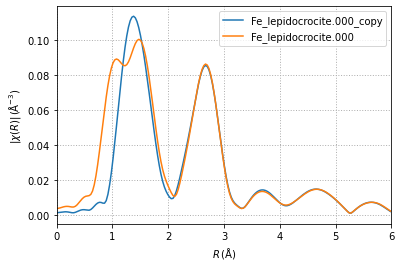

In [9]:
# https://vimeo.com/340215763 05:50
# change rbkg to a larger number and redo calculations
# with modified bacground parameter
autobk(fe_xafs_copy, rbkg=1.2)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

# plot magnitude in r-space to see results of change
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

Following the discussion, the safe intervals where the results are about the same range from 0.8 to 1.0. This is important because the parameters to extract from the data during analysis (i.e. the structural infomation) correlate to the values provided by background removal. According to Ravel, the structural analysis in the range above (0.8 to 1.0), should all produce very similar results.

## Changing k-weight
Other parameters can also influence data analysis. For instance looking again at the initial group, we can analise how kweight affects the analyis. First take a look at backgroun in energy. In this case, the values after 7200 are so close to the background that they seem to disappear. However, the data still contains useful values which can be enhanced to reveal meaningful information.

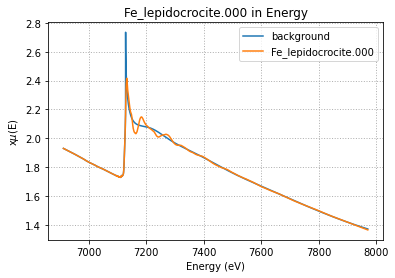

In [10]:
# https://vimeo.com/340215763 12:08
plt.plot(fe_xafs.energy, fe_xafs.bkg, label='background')
plt.plot(fe_xafs.energy, fe_xafs.mu, label=fe_xafs.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs.filename+" in Energy")
plt.legend()

This can be observed by plotting in the k space whith kweight 2.This enhances the signals after 6, making them more evident for analysis.

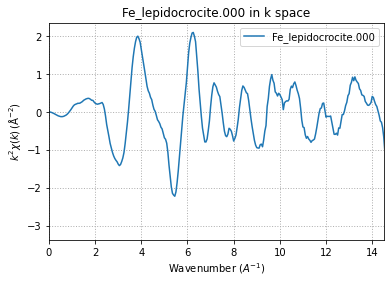

In [11]:
# https://vimeo.com/340215763 12:37
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label=fe_xafs.filename)
plt.xlabel(r'Wavenumber ($A^{-1}$)')
plt.ylabel(plab.chikw.format(2))
plt.title(fe_xafs.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)
plt.legend()

This same signal before amplification can be seen in the following diagram. in this case, whitout amplification is difficult to see values above 6.

(0.0, 14.5)

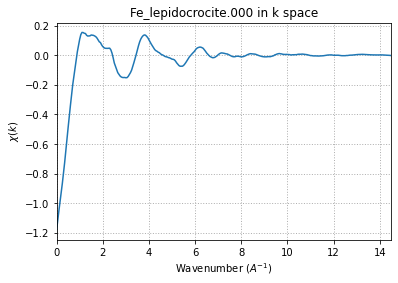

In [12]:
# https://vimeo.com/340215763 14:16
plt.plot(fe_xafs.k, fe_xafs.chi)
plt.ylabel(r'$\chi(k)$')
plt.xlabel(r'Wavenumber ($A^{-1}$)')
plt.title(fe_xafs.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)

The signal can be amplified by a k-weight of 1, and it starts showing more data, as shown below.

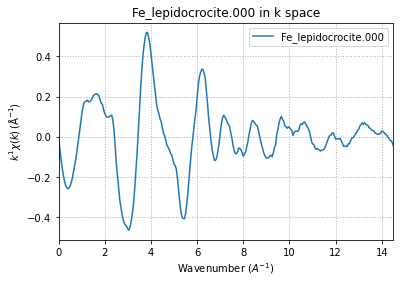

In [13]:
# https://vimeo.com/340215763 14:23
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k, label=fe_xafs.filename)
plt.xlabel(r'Wavenumber ($A^{-1}$)')
plt.ylabel(plab.chikw.format(1))
plt.title(fe_xafs.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)
plt.legend()

Changing the kweight also affects the shape of the fourier transform. The following diagram shows the fourier transforms when k-weight is 1 and 2

(0.0, 6.0)

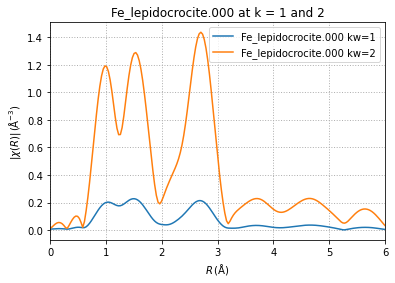

In [14]:
xftf(fe_xafs, kweight=1.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
# https://vimeo.com/340215763 15:40
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=1")
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)
xftf(fe_xafs, kweight=2.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
# https://vimeo.com/340215763 15:40
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=2")
plt.title(fe_xafs.filename+" at k = 1 and 2")
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

And then the function of athena that allows visualising with different k-weights can be replicated as follows

(0.0, 6.0)

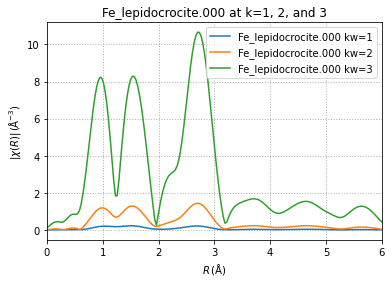

In [15]:
xftf(fe_xafs, kweight=1.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
# https://vimeo.com/340215763 16:24
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=1")
xftf(fe_xafs, kweight=2.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
# https://vimeo.com/340215763 15:40
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=2")
xftf(fe_xafs, kweight=3.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
# https://vimeo.com/340215763 15:40
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=3")
plt.title(fe_xafs.filename+" at k=1, 2, and 3")
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

Alternatively, the calculation can be seen side by side using subplots as follows

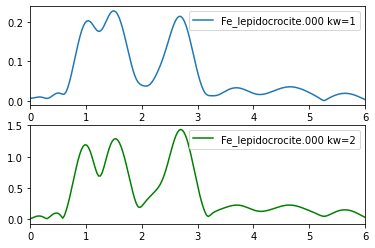

In [16]:
plt.subplot(2, 1, 1)
plt.xlim(0,6)
xftf(fe_xafs, kweight=1.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename+" kw=1")
plt.legend()
plt.subplot(2, 1, 2)
plt.xlim(0,6)
xftf(fe_xafs, kweight=2.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
plt.plot(fe_xafs.r, fe_xafs.chir_mag, 'g', label=fe_xafs.filename+" kw=2" )
plt.legend()

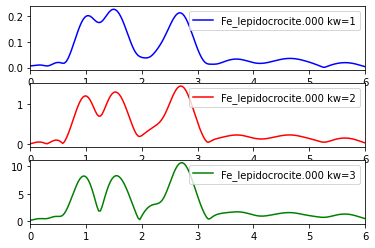

In [17]:
plt.subplot(3, 1, 1)
plt.xlim(0,6)
xftf(fe_xafs, kweight=1.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
plt.plot(fe_xafs.r, fe_xafs.chir_mag, 'b', label=fe_xafs.filename+" kw=1")
plt.legend()
plt.subplot(3, 1, 2)
plt.xlim(0,6)
xftf(fe_xafs, kweight=2.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
plt.plot(fe_xafs.r, fe_xafs.chir_mag, 'r', label=fe_xafs.filename+" kw=2")
plt.legend()
plt.subplot(3, 1, 3)
plt.xlim(0,6)
xftf(fe_xafs, kweight=3.0, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
plt.plot(fe_xafs.r, fe_xafs.chir_mag, 'g', label=fe_xafs.filename+" kw=3")
plt.legend()

this illustrates how changing the k-weight the sizes and shapes of the peaks also change, but this is not significan for the analysis as they seem equivalent. But, depending the sample and the data, kweight adjustment may be needed.

## Import more data

At 28:00